In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Attention, Dropout, BatchNormalization
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import kerastuner as kt
import random

# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# Load Dataset
dataset_path1 = 'btc_data.csv'
df_train = pd.read_csv(dataset_path1)

# Load Dataset
dataset_path2 = 'BTC-USD.csv'
df_test = pd.read_csv(dataset_path2)

# Define the target variable
target = 'BTC_Close'


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_normalized = scaler.fit_transform(df_train[target].values.reshape(-1, 1))
data_test_normalized = scaler.fit_transform(df_test[target].values.reshape(-1, 1))

# Prepare data for GRU
sequence_length = 20
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(data_train_normalized, sequence_length)
x_test, y_test = create_sequences(data_test_normalized, sequence_length)

# Hyperparameter Optimization using Keras Tuner
def build_model(hp):
    inputs = Input(shape=(sequence_length, 1))
    # Hyperparameter tuning for the number of units and dropout rates
    gru_output = GRU(hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=False)(inputs)
    gru_output = BatchNormalization()(gru_output)
    gru_output = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(gru_output)
    
    dense_output = Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(gru_output)
    dense_output = Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1))(dense_output)
    dense_output = Dense(1)(dense_output)

    # Compile GRU model
    model = Model(inputs, dense_output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Hyperparameter tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='gru_xgb_tuner',
    project_name='gru_xgb'
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search for best hyperparameters
tuner.search(x_train, y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping])

# Get the best hyperparameters
gru_best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best GRU Hyperparameters:')
print(gru_best_hyperparameters.values)

# Get the best model
gru_model = tuner.get_best_models(num_models=1)[0]

# Train the best GRU model
gru_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

# Extract features from GRU model
feature_extractor = Model(inputs=gru_model.input, outputs=gru_model.layers[-3].output)
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

# Set up hyperparameter optimization for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor()
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Train XGBoost with optimized hyperparameters
random_search.fit(train_features, y_train)

# Print best hyperparameters for XGBoost
print('Best XGBoost Hyperparameters:')
print(random_search.best_params_)
xgb_best = random_search.best_estimator_

# Make predictions
y_pred = xgb_best.predict(test_features)

# Rescale predictions
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

Trial 5 Complete [00h 00m 15s]
val_loss: 0.0006878178101032972

Best val_loss So Far: 0.0006213804590515792
Total elapsed time: 00h 01m 10s
Best GRU Hyperparameters:
{'units': 224, 'dropout': 0.30000000000000004, 'dense_units': 128, 'dropout_2': 0.2}
Epoch 1/50


c:\Users\Kiet Le\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0045 - val_loss: 8.8529e-04
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0129
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0216
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 5.9565e-04
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 8.0938e-04
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0105
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 8.7302e-04
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms

RMSE: 1966.888765307355
MAE: 1467.4430658417627
R²: 0.9696955311166859
MAPE: 2.3526623495156382%
Directional Accuracy (DA): 47.53623188405797%


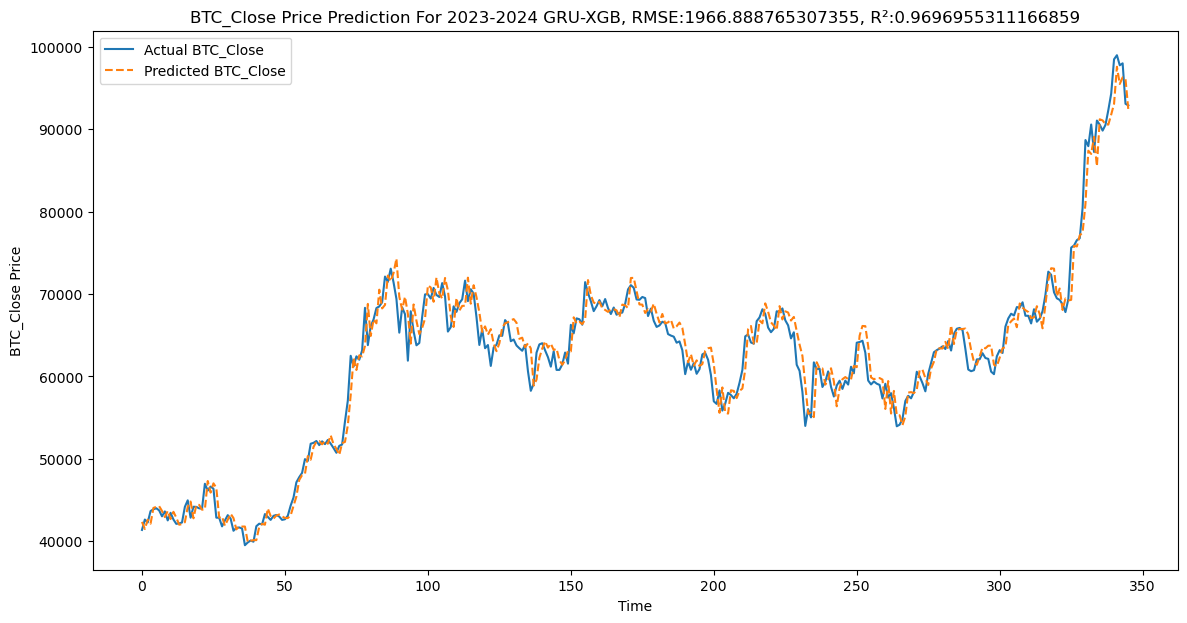

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate RMSE, MAE, R²
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

da = directional_accuracy(y_test_rescaled, y_pred_rescaled)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')
print(f'MAPE: {mape}%')
print(f'Directional Accuracy (DA): {da}%')

# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual BTC_Close')
plt.plot(y_pred_rescaled, label='Predicted BTC_Close', linestyle='dashed')
plt.title(f'BTC_Close Price Prediction For 2023-2024 GRU-XGB, RMSE:{rmse}, R²:{r2}')
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()


In [3]:
print(df_train.shape)
print(df_test.shape)
print(f"X_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

(2430, 48)
(366, 8)
X_train.shape: (2410, 20, 1)
y_train.shape: (2410, 1)
X_test.shape: (346, 20, 1)
y_test.shape: (346, 1)
